<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B8%D1%80%D1%83%D0%B5%D0%BC_%D0%B0%D0%BD%D0%B8%D0%BC%D0%B5_%D0%BF%D0%B5%D1%80%D1%81%D0%BE%D0%BD%D0%B0%D0%B6%D0%B5%D0%B9_%D0%BF%D1%80%D0%B8_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D0%B8_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерируем аниме персонажей при помощи GAN


# Generating anime characters with GAN


Наша цель в этом уроке сгенерировать лица аниме персонажей с помощью **Deep Convolutional Generative Adversarial Network (DCGAN).**



Our goal in this lesson is to generate anime character faces using the **Deep Convolutional Generative Adversarial Network (DCGAN).**




## Немного теории 

## A bit of theory 


**GAN** или же **генеративные состязательные сети** - это один из алгоритмов машинного обучения, который заключается в комбинации двух нейросетей: **генератора** и **дискриминатора**. Задача генератора – генерировать образы заданной категории. Задача дискриминатора – пытаться распознать созданный образ.



На каждом шаге дискриминатор обучается распознавать подлинность изображения, в то самое время генератор учится все точнее и точне создавать новые изображения.
В нашей архитектуре будем использовать сверточные слои как в дискриминаторе, так и в генераторе, чтобы создать эффективные GAN для изображений.





At each step, the discriminator learns to recognize the authenticity of the image, while the generator learns to create new images more and more accurately.
In our architecture we will use convolutional layers in both discriminator and generator to create efficient GANs for images.


**Deep Convolutional GAN** имеет следующую структуру:

**Deep Convolutional GAN** has the following structure:


### Генератор

### Generator


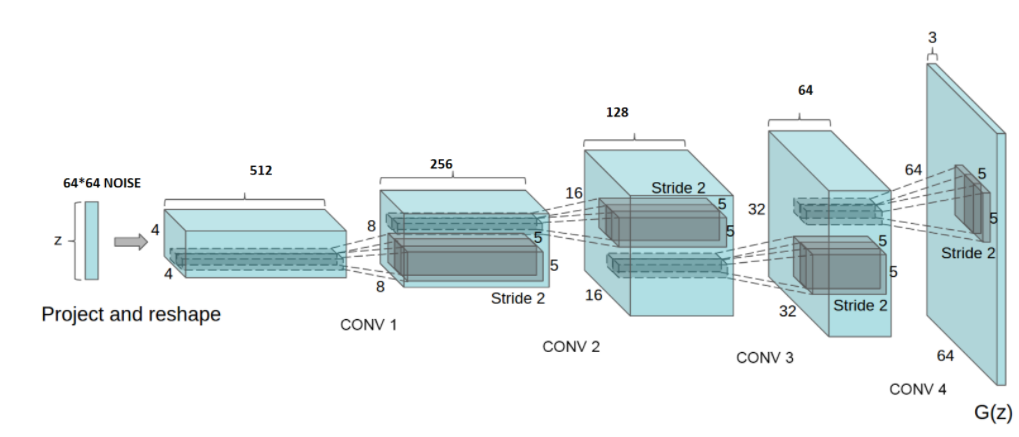


Он принимает на входе вектор шума, который пропускается через все сверточные слои. Помимо свертки есть слои транспонирования, за которыми следует пакетная нормализация и функция активации LeakyReLU. 

It takes a noise vector as input, which is passed through all convolution layers. In addition to convolution, there are transpose layers, followed by batch normalization and LeakyReLU activation function. 

В упрощенном виде после тренировки каждое измерение будет соответствовать характеристике изображения, например форме волос персонажа.




In simplified form, after training, each dimension will correspond to a characteristic of the image, such as the shape of a character's hair.

### Дискриминатор

### Discriminator


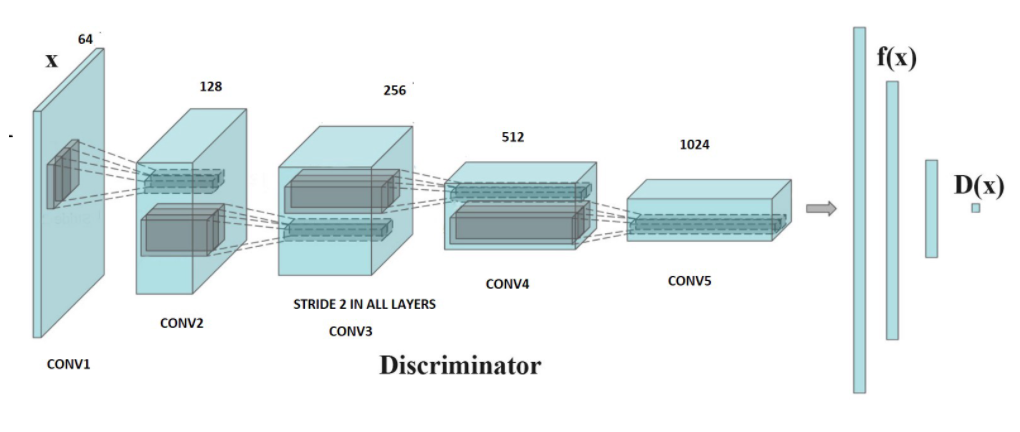

Дискриминатор также состоит из слоев свертки, где мы используем шаги для понижения дискретизации и пакетной нормализации для стабильности.

The discriminator also consists of convolution layers, where we use steps for downsampling and batch normalization for stability.

Фактически, дискриминатор — это бинарный классификатор на основе простой CNN, который на выходе выдает 1 или 0.




In fact, the discriminator is a binary classifier based on a simple CNN, which outputs a 1 or 0.

## Код

## Code


In [1]:
!wget http://dataudt.ru/datasets/cv/anime_faces_dataset.zip
!unzip anime_faces_dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: anime_faces_dataset/5499.png  
  inflating: anime_faces_dataset/55.png  
  inflating: anime_faces_dataset/550.png  
  inflating: anime_faces_dataset/5500.png  
  inflating: anime_faces_dataset/5501.png  
  inflating: anime_faces_dataset/5502.png  
  inflating: anime_faces_dataset/5503.png  
  inflating: anime_faces_dataset/5504.png  
  inflating: anime_faces_dataset/5505.png  
  inflating: anime_faces_dataset/5506.png  
  inflating: anime_faces_dataset/5507.png  
  inflating: anime_faces_dataset/5508.png  
  inflating: anime_faces_dataset/5509.png  
  inflating: anime_faces_dataset/551.png  
  inflating: anime_faces_dataset/5510.png  
  inflating: anime_faces_dataset/5511.png  
  inflating: anime_faces_dataset/5512.png  
  inflating: anime_faces_dataset/5513.png  
  inflating: anime_faces_dataset/5514.png  
  inflating: anime_faces_dataset/5515.png  
  inflating: anime_faces_dataset/5516.png  
  inflating:

Импортируем библиотеки 

Importing libraries 


In [4]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
#from keras.optimizers import Adam # Оптимизатор 
                                # Optimizer 
from tensorflow.keras.optimizers import Adam                               
from keras.models import Sequential, Model # Формат модели keras
                                            # The format of the keras model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input # Базовые слои keras
                                                                    # keras base layers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

Загружаем изображения


Uploading images


In [5]:
def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # перебираем структуру каталогов
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # перебираем имена файлов в текущем каталоге
        # loop over the filenames in the current directory
        for filename in filenames:
            # если строка contains не является None и имя файла
            #  не содержит заданную строку, то мы игнорируем файл
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # определяем расширение текущего файла
            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # проверяем, является ли файл изображением и должен ли он быть обработан
            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # строим путь к изображению и отдаем его
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

In [6]:
def list_images(basePath, contains=None):
    # возвращает набор файлов нужного формата
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

In [7]:
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Целые числа, соответствующие категориям в алфавитном порядке
                # Whole numbers corresponding to categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) # читаем изображение с помощью OpenCV
                                    # read the image with OpenCV
            image = cv2.resize(image,size) # изменяем размер изображения, чтобы 
                                            # все были одинакового размера
                                             # resize the image so that 
                                            # all be the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [8]:
images=load_images('anime_faces_dataset')

Посмотрим для примера на случайные изображения из набора


Let's look at random images from the set as an example


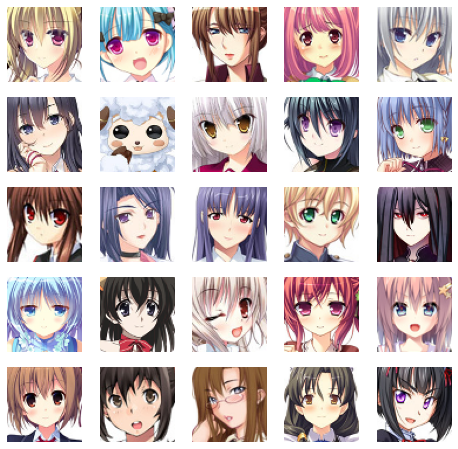

In [11]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

Теперь построим саму модель


Now let's build the model itself


In [12]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3) # размер изображения
                                    # image size
        self.noise_size = 100 # размер шума
                                # the size of the noise

        # в качестве оптимизатора берем Adam
        # as an optimizer we take Adam
        optimizer = Adam(0.0002,0.5)

        # инициализируем дискриминатор на основе функции, которую напишем ниже 
        # initialize the discriminator based on the function we write below 
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # инициализируем генератор на основе функции, которую напишем ниже 
        # initialize the generator based on the function we write below 
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        # инициализируем комбинированную модель
        # initialize the combined model
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        # замораживаем веса
        # это будет означать что если дискриминатор входит в состав другой модели, изменяться веса не будут
        # freeze the weights
        # this will mean that if the discriminator is part of another model, the weights will not change
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        # выведем описание созданной модели
        # outputs a description of the created model
        self.combined.summary()
        
    
    # строим генератор 
    # большие ядра в конволюционных слоях позволяют сети создавать сложные структуры
    # building a generator 
    # large cores in convolutional layers allow the network to create complex structures
    def build_generator(self):
        epsilon = 0.00001 # небольшое плавающее число, добавленное к дисперсии, чтобы 
                        # избежать деления на ноль в слоях BatchNorm.
                        # a small floating number added to the variance to 
                        # avoid division by zero in the BatchNorm layers.

        noise_shape = (self.noise_size,)
        
        # инициализируем модель generator
        # initialize the generator model
        model = Sequential()
        # Добавляем Dense-слой на 8192 нейронов (размерность входных данных = noise_shape)
        # Add a Dense layer with 8192 neurons (input dimension = noise_shape)
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))  # слой функции активации с параметром 0.2
                                        # activation function layer with parameter 0.2
        model.add(Reshape((4, 4, 512))) # слой Reshape
                                        # Reshape layer
        
        # сверточный слой с транспонированием 
        # convolution layer with transposition 
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))) 
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon)) # нормализация normalization
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        
        # сверточный слой с транспонированием
        # convolution layer with transposition 
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon)) # нормализация normalization
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        
        # сверточный слой с транспонированием
        # convolution layer with transposition 
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon)) # нормализация normalization
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        
        # сверточный слой с транспонированием
        # convolution layer with transposition 
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon)) # нормализация normalization
        model.add(LeakyReLU(alpha=0.2))  #  функция активации activation function
        
        # сверточный слой с транспонированием
        # convolution layer with transposition
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # стандартная активация для генератора GAN
        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        # выведем описание созданной модели
        # outputs a description of the created model
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        # инициализируем модель discriminator
        # initialize the discriminator model
        model = Sequential()

        
        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape)) # сверточный слой convolution layer
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        model.add(BatchNormalization())# нормализация normalization
        model.add(Conv2D(128, (3,3), padding='same')) # сверточный слой convolution layer
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        model.add(BatchNormalization()) # нормализация normalization
        model.add(MaxPooling2D(pool_size=(3,3))) # уменьшаем размер ввода  reduce the size of the input
        model.add(Dropout(0.2)) # прореживаем сеть при помощи дропаута
                                # thinning the network with a dropout

        model.add(Conv2D(128, (3,3), padding='same')) # свертка convolution layer
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        model.add(BatchNormalization()) # нормализация normalization
        model.add(Conv2D(128, (3,3), padding='same')) # свертка convolution layer
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        model.add(BatchNormalization()) # нормализация normalization
        model.add(MaxPooling2D(pool_size=(3,3))) # уменьшаем размер ввода reduce the size of the input
        model.add(Dropout(0.3)) # прореживаем сеть при помощи дропаута
                                # thinning the network with a dropout

        model.add(Flatten()) # сглаживаем тензор smoothing the tensor
        model.add(Dense(128))  # полносвязный слой Dense layer
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        model.add(Dense(128))# полносвязный слой Dense layer
        model.add(LeakyReLU(alpha=0.2)) #  функция активации activation function
        model.add(Dense(1, activation='sigmoid')) # Dense слой c 1 нейроном с активационной функцией sigmoid
                                                # Dense layer with 1 neuron with sigmoid activation function

        # выведем описание созданной модели
        # outputs a description of the created model
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        # инициализируем картинки 
        # initialize pictures 
        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        # получаем половину батча
        # get half of the batch
        half_batch = int(batch_size / 2)
        
        # инициализируем массив значений ошибки  и генератора
        # initialize the array of error and generator values
        mean_d_loss=[0,0]
        mean_g_loss=0

        # проходимся по всем эпохам 
        # going through all the eras 
        for epoch in range(epochs):
             # создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной half_batch
             # и в переменную imgs записываем значение из X_train с индексами из idx
             # create an array of random values between 0 and X_train.shape[0] of length half_batch
             # and write the value from X_train with indexes from idx into the variable imgs
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # создаем массив размерностью (half_batch,noise_size) из нормально распределенных значений
            # create an array of (half_batch,noise_size) normally distributed values
            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            # предсказываем картинку с помощью генератора
            # predicting a picture using a generator
            gen_imgs = self.generator.predict(noise)

            # Обучение дискриминатора
            # Training the discriminator
            
            # d_loss (потери дискриминатора) - это среднее значение потерь при обучении на подлинных и поддельных изображениях
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # обучаем генератор
            # Training the generator
            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            # вычисляем ошибку  
            # calculate the error  
            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            # суммируем ошибки 
            # summarize the errors 
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # выводим потери и точность сетей каждые 200 партий,
            #  главным образом для того, чтобы убедиться, что точность дискриминатора не стабильна 
            # на уровне 50% или 100% (что означало бы, что дискриминатор работает недостаточно хорошо или слишком хорошо)
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # сохраняем 25 изображений
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            # Мы сохраняем архитектуру модели, веса и состояние оптимизатора.
            # Таким образом, мы можем начать обучение точно с того места, где остановились.
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # сохраняем 25 сгенерированных изображений, чтобы иметь представление о спектре изображений, созданных генератором
    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # меняем масштаб с [-1,1] на [0,1]
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

       # строим графики и сохраняем 
       # graphing and saving 
        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

In [13]:
# В этой папке будут храниться изображения, созданные во время обучения
# This folder will contain the images generated during the training
!mkdir animeGenerated


Обучение GAN сильно отличается от обучения обычной нейронной сети. Основное отличие заключается в том, что дискриминатор также развивается, поэтому функция стоимости, которую генератор пытается минимизировать, также развивается. 

GAN training is very different from training a regular neural network. The main difference is that the discriminator also evolves, so the cost function that the generator tries to minimize also evolves. 

Дискриминатор должен быть достаточно мощным, чтобы распознавать небольшие различия между реальным и поддельным изображениями.
Если дискриминатор не работает должным образом, генератор не может работать исправно. Даже при 50 % точности у дискриминатора генератор не сможет исправно работать. Поэтому важно обучать эти сети параллельно, чтобы избежать уменьшения градиента во время тренировки генератора.


The discriminator must be powerful enough to recognize small differences between the real and fake images.
If the discriminator does not work properly, the generator cannot work properly. Even with 50% accuracy in the discriminator, the oscillator cannot work properly. Therefore, it is important to train these networks in parallel to avoid gradient reduction during generator training.


Обучим наконец нашу модель. 


Let's finally train our model. 

Для этого укажем кол-во эпох, размер батча и чекпоинты при которых мы будем сохранять модель, изображения и веса. 

To do this, specify the number of epochs, batch size, and checkpoints at which we will save the model, images, and weights. 

Возьмем побольше размер партии, так как большой размер приводит к более регулярной сходимости.

Let's take a larger batch size, since a larger size leads to a more regular convergence.

Будем просматривать образцы изображений каждые 1000 эпох.








We will look through samples of images every 1000 epochs.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                        

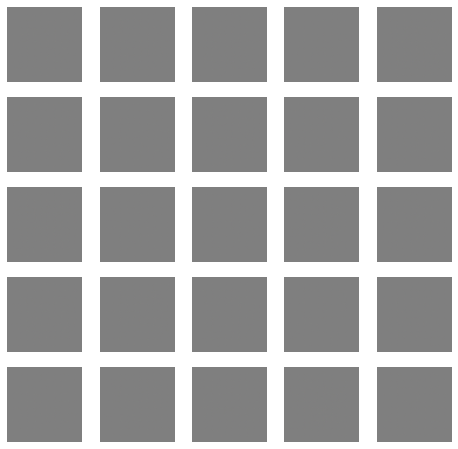

INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


200 [Discriminator loss: 0.371280, acc.: 86.93%] [Generator loss: 2.653636]
400 [Discriminator loss: 0.452871, acc.: 79.48%] [Generator loss: 2.907644]
600 [Discriminator loss: 0.369382, acc.: 83.88%] [Generator loss: 2.841212]
800 [Discriminator loss: 0.338198, acc.: 85.38%] [Generator loss: 3.404263]
1000 [Discriminator loss: 0.337654, acc.: 85.40%] [Generator loss: 3.517998]


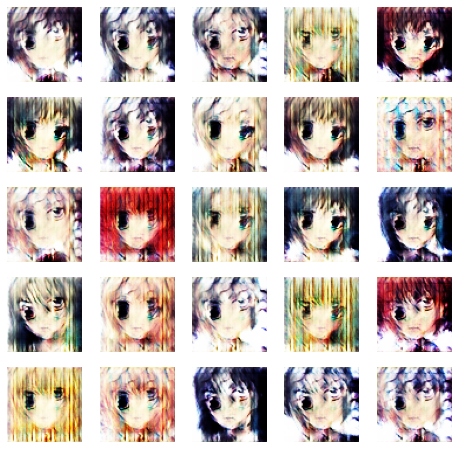

1200 [Discriminator loss: 0.288062, acc.: 88.41%] [Generator loss: 3.841813]
1400 [Discriminator loss: 0.324071, acc.: 86.36%] [Generator loss: 3.683077]
1600 [Discriminator loss: 0.365141, acc.: 83.82%] [Generator loss: 3.403982]
1800 [Discriminator loss: 0.369805, acc.: 83.58%] [Generator loss: 3.375101]
2000 [Discriminator loss: 0.344650, acc.: 84.88%] [Generator loss: 3.170005]


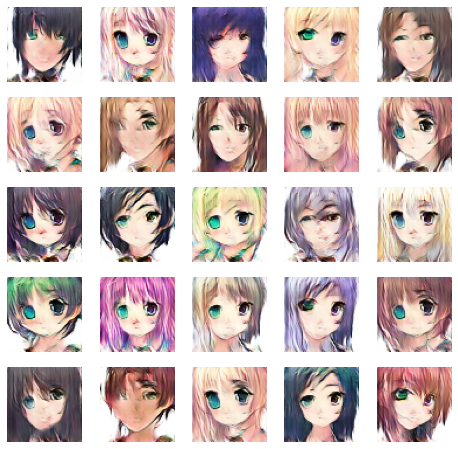

2200 [Discriminator loss: 0.356627, acc.: 84.54%] [Generator loss: 3.069340]
2400 [Discriminator loss: 0.280769, acc.: 88.32%] [Generator loss: 2.615615]
2600 [Discriminator loss: 0.348114, acc.: 85.71%] [Generator loss: 2.610212]
2800 [Discriminator loss: 0.363057, acc.: 84.37%] [Generator loss: 2.698551]
3000 [Discriminator loss: 0.373928, acc.: 83.55%] [Generator loss: 2.829363]


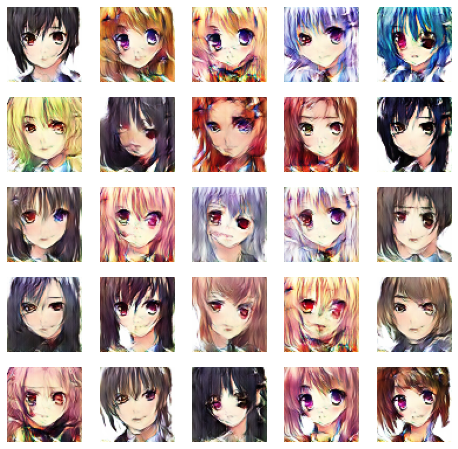

3200 [Discriminator loss: 0.288303, acc.: 88.41%] [Generator loss: 2.177808]
3400 [Discriminator loss: 0.315472, acc.: 86.64%] [Generator loss: 2.571001]
3600 [Discriminator loss: 0.337144, acc.: 85.71%] [Generator loss: 2.653764]
3800 [Discriminator loss: 0.324954, acc.: 86.13%] [Generator loss: 2.643732]


KeyboardInterrupt: ignored

In [14]:
gan=GAN()
gan.train(epochs=15001, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)

После обучения многие изображения выглядят убедительно. Средняя точность во время обучения была около 90%, что звучит довольно неплохо. 


After training, many of the images look convincing. The average accuracy during training was about 90%, which sounds pretty good. 